<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/240126_rl_LunarLander_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- task: https://gymnasium.farama.org/environments/box2d/lunar_lander/
- https://qiita.com/siruku6/items/9b6347ad6c5a891b61f1
- https://note.com/npaka/n/n784a13c44fa7

- https://www.kaggle.com/c/connectx/overview
- https://www.kaggle.com/code/ajeffries/connectx-getting-started
- https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning/tutorial
- https://www.kaggle.com/code/toshikazuwatanabe/connect4-make-submission-with-stable-baselines3


# 1. install / import module

In [ ]:
# NOTE: gymnasium[box2d] を install するために必要
#   swig がないと、"ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects" が発生する
# https://stackoverflow.com/questions/76222239/pip-install-gymnasiumbox2d-not-working-on-google-colab
!pip install -q swig

!pip install -q gymnasium[box2d]


  Preparing metadata (setup.py) ... done


In [ ]:
# colabortory 上で gymnasium のゲーム実行結果を録画するためのモジュールインストール
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg
!pip install -q pyvirtualdisplay


# 2. LunarLander の動作確認

## 2-1. 実行結果を録画

In [ ]:
# Colab上で仮想ディスプレイを使用するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

import gym
from gym.wrappers import RecordVideo
from IPython import display as ipythondisplay
from IPython.display import HTML


In [ ]:
# LunarLander環境の作成
env = gym.make("LunarLander-v2")

# 録画用の RecordVideo ラッパーの作成
video_path = "/content/lunar_lander_video"  # 保存先
env = RecordVideo(env, video_path)

# エピソードの実行
num_episodes = 5
for episode in range(num_episodes):
    observation = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample()  # ランダムな行動の選択
        observation, reward, done, _ = env.step(action)
        total_reward += reward

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")


# 動画の保存先の表示
video_path

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lunar_lander_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording abilit

Episode 1, Total Reward: -109.48552757315353


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 2, Total Reward: -140.23207423453118
Episode 3, Total Reward: -225.84344004730804
Episode 4, Total Reward: -342.29615683726183
Episode 5, Total Reward: -47.62287418643385


'/content/lunar_lander_video'

## 2-2. 出力の形状や値を確認

In [ ]:
env.action_space.sample()


1

In [ ]:
observation


array([-0.5108868 , -0.06801012, -1.3691006 , -0.22762576,  1.1895872 ,
        3.6116757 ,  0.        ,  1.        ], dtype=float32)

# 3. 実装

## 3-1. experience replay 用クラス


In [ ]:
from collections import deque
import random
from typing import Any, Dict

import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F


In [ ]:
class ReplayBuffer(object):
    def __init__(self, buffer_size: int, batch_size: int) -> None:
        self.buffer: deque = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done) -> None:
        data: Dict[str, Any] = {
            "state": state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done,
        }
        self.buffer.append(data)

    def __len__(self) -> int:
        return len(self.buffer)

    def pick_batch(self) -> tuple:
        batch = random.sample(self.buffer, self.batch_size)

        state_batch = np.stack([x["state"] for x in batch], axis=0)
        action_batch = np.array([x["action"] for x in batch])
        reward_batch = np.array([x["reward"] for x in batch])
        next_state_batch = np.stack([x["next_state"] for x in batch], axis=0)
        done_batch = np.array([x["done"] for x in batch]).astype(np.int32)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch


### experience replay の動作確認

In [ ]:
env = gym.make("LunarLander-v2")
replay_buf = ReplayBuffer(buffer_size=100, batch_size=10)

for episode in range(10):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        replay_buf.add(state, action, reward, next_state, done)
        state = next_state

(
    state_batch,
    action_batch,
    reward_batch,
    next_state_batch,
    done_batch,
) = replay_buf.pick_batch()


(
    state_batch.shape,
    action_batch.shape,
    reward_batch.shape,
    next_state_batch.shape,
    done_batch.shape,
)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


((10, 8), (10,), (10,), (10, 8), (10,))

## 3-2. DQN クラス

In [ ]:
import copy

from tqdm.notebook import tqdm

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F


In [ ]:
class QNet(nn.Module):
    def __init__(self, action_size: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(8, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, action_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class DQNAgent:
    def __init__(self) -> None:
        self.gamma: float = 0.98
        self.lr: float = 0.0005
        # self.epsilon: float = 0.1
        self.epsilon: float = 0.075
        self.buffer_size: int = 10000
        self.batch_size: int = 32
        self.action_size: int = 4

        self.replay_buffer: tuple = ReplayBuffer(
            buffer_size=self.buffer_size,
            batch_size=self.batch_size
        )

        self.qnet = QNet(action_size=self.action_size)
        self.qnet_target = QNet(action_size=self.action_size)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)

    def sync_qnet(self) -> None:
        self.qnet_target = copy.deepcopy(self.qnet)

    def get_action(self, state: torch.Tensor, deterministic: bool = False) -> int:
        if (not deterministic) and (np.random.rand() < self.epsilon):
            action: int = np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]  # (8,) -> (1, 8)
            torch_state: torch.Tensor = torch.from_numpy(
                state.astype(np.float32)
            ).float()
            qs: torch.Tensor = self.qnet(torch_state)
            action: int = qs.data.argmax().item()
            # print("action from Q:", action)

        return action

    def update(
        self,
        state: np.ndarray,
        action: int,
        reward: np.ndarray,
        next_state: np.ndarray,
        done: int,
    ) -> None:
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        (
            state_batch,
            action_batch,
            reward_batch,
            next_state_batch,
            done_batch,
        ) = self.replay_buffer.pick_batch()

        torch_state_batch: torch.Tensor = torch.from_numpy(
            state_batch.astype(np.float32)
        )
        qs = self.qnet(torch_state_batch)
        q = qs[np.arange(self.batch_size), action_batch]

        torch_next_state_batch: torch.Tensor = torch.from_numpy(
            next_state_batch.astype(np.float32)
        )
        next_qs = self.qnet_target(torch_next_state_batch)
        # next_q = next_q.unchain()
        next_qs = next_qs.detach()
        # next_q = next_qs.max(axis=1)
        next_q = next_qs.max(dim=1).values

        torch_reward_batch: torch.Tensor = torch.from_numpy(
            reward_batch.astype(np.float32)
        )
        target = (torch_reward_batch + self.gamma * next_q * (1 - done_batch)).float()

        loss_func = nn.MSELoss()
        loss = loss_func(q, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3-3. DQN の学習

In [ ]:
episodes = 1500
sync_interval = 20
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
agent = DQNAgent()
reward_log = []

for episode in tqdm(range(episodes)):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    reward_log.append(total_reward)
    if episode % sync_interval == 0:
        agent.sync_qnet()
        # print(f"episode: {episode}, reward: {total_reward}")

    reward_log.append(total_reward)
    if episode % 100 == 0:
        print(f"episode: {episode}, reward: {total_reward}")


  0%|          | 0/1500 [00:00<?, ?it/s]

episode: 0, reward: -438.54453129636676
episode: 0, reward: -438.54453129636676
episode: 20, reward: -439.162422798854
episode: 40, reward: -64.22651194335799
episode: 60, reward: -280.8380546655906
episode: 80, reward: -719.1272887604861
episode: 100, reward: -110.76146624297515
episode: 100, reward: -110.76146624297515
episode: 120, reward: -165.14246246767982
episode: 140, reward: -3.2405586657794174
episode: 160, reward: -238.30744525774003
episode: 180, reward: -85.43564950577026
episode: 200, reward: -102.81957716242648
episode: 200, reward: -102.81957716242648
episode: 220, reward: -102.58314735738392
episode: 240, reward: 56.028349954183994
episode: 260, reward: -97.97432986614284
episode: 280, reward: -82.4068194215772
episode: 300, reward: -85.94505148262476
episode: 300, reward: -85.94505148262476
episode: 320, reward: -177.0821426937424
episode: 340, reward: -121.70618612976018
episode: 360, reward: -177.53805202242836
episode: 380, reward: -98.90496751897196
episode: 400, 

## 3-4. DQN で推論

colaboratory 上に描画

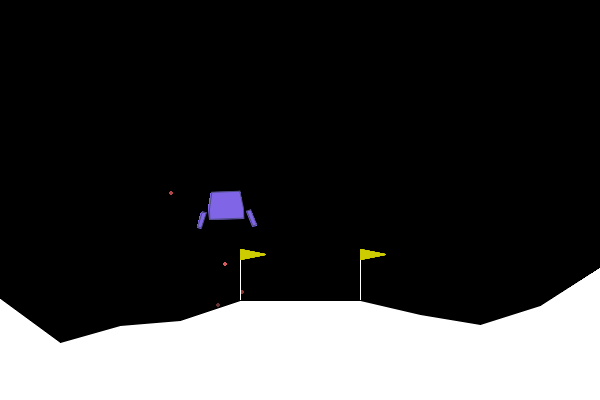

In [ ]:
from IPython import display

# 推論
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)
env.action_space.seed(42)
state = env.reset(seed=42)


with torch.no_grad():
    for _ in tqdm(range(2000)):
        action: int = agent.get_action(state, deterministic=True)
        observation, reward, done, info = env.step(action)
        state = observation
        display.clear_output(wait=True)
        display.display(
            Image.fromarray(env.render(mode='rgb_array'))
        )
        time.sleep(0.08)
        if done:
            env.reset()

env.close()


録画する場合 (こちらの動作は未確認)

In [ ]:
import time
from PIL import Image


# 推論
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power  = 1.5,
)
env.action_space.seed(42)

# 録画用の RecordVideo ラッパーの作成
video_path = "/content/lunar_lander_video"  # 保存先
env = RecordVideo(env, video_path)

state = env.reset(seed=42)



# # エピソードの実行
# num_episodes = 5
# for episode in range(num_episodes):
#     observation = env.reset()

#     while not done:
#         action = env.action_space.sample()  # ランダムな行動の選択
#         observation, reward, done, _ = env.step(action)



with torch.no_grad():
    for step in tqdm(range(2000)):
        action: int = agent.get_action(state)
        observation, reward, done, info = env.step(action)
        # state = observation
        # display.clear_output(wait=True)
        # display.display(
        #     Image.fromarray(env.render(mode='rgb_array'))
        # )
        # time.sleep(0.08)
        total_reward += reward
        if done:
            print(f"Step {step + 1}, Total Reward: {total_reward}")
            total_reward = 0
            env.reset()

env.close()
